This notebook is a minimum example of a problem I have in defining multi-dimensional prior probabilities in mixture models. I first simulate artificial data from a Gaussian mixture and then try to infer the underlying components using two pyro models. In the first model each component has equal prior probability and I can In the second model I 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoLowRankMultivariateNormal
from pyro.infer.autoguide.initialization import init_to_value
from pyro.infer import SVI, config_enumerate, TraceEnum_ELBO, infer_discrete

In [2]:
# Produce some artificial data:         
n_components = 2
n_observations = 100

mus_k = torch.tensor(np.array((5.,20.)), dtype = torch.float32)
weights_k = torch.tensor(np.ones(n_components)/n_components, dtype = torch.float32)
k_c = pyro.sample('k_c', dist.Categorical(weights_k).expand([n_observations]).to_event(1))
data = pyro.sample("obs", dist.Normal(loc = mus_k[k_c], scale = 1).expand([n_observations]).to_event(1))

This Gaussian mixture model has a 1D weights prior, so the same for all observations:

In [3]:
# Define 1D Gaussian mixture model with two components
@config_enumerate 
def model(data):
    
    n_observations= len(data)
    n_components = 2
    scale = 1
    
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(torch.ones(n_components)))
    locs = pyro.sample('locs', dist.Normal(10., 10.).expand([n_components]).to_event(1))

    # Local variables.
    with pyro.plate('observations', n_observations):
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)

We can infer the right components using this model:

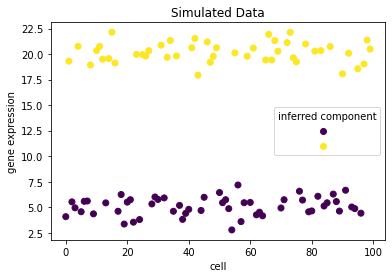

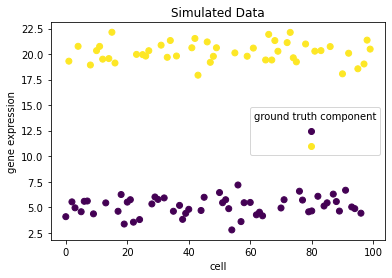

In [4]:
# Make appropriate auto guide (and hiding discrete variable)
global_guide = AutoLowRankMultivariateNormal(poutine.block(model, hide=['assignment']),
                        init_to_value(values = {'locs': torch.tensor(np.array((1.,10.)), dtype = torch.float32)}))

# Train model:
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, global_guide, optim, loss=elbo)
for i in range(200):
    loss = svi.step(data)

# Predict components:
guide_trace = poutine.trace(global_guide).get_trace(data)  # record the globals
trained_model = poutine.replay(model, trace=guide_trace)  # replay the globals
def classifier(data, temperature=0):
    inferred_model = infer_discrete(trained_model, temperature=temperature,
                                    first_available_dim=-2)  # avoid conflict with data plate
    trace = poutine.trace(inferred_model).get_trace(data)
    return trace.nodes["assignment"]["value"]
k_c_inferred = classifier(data)

# Plot ground truth and inferred components:
scatter = plt.scatter(range(len(data)), data, c = k_c_inferred)
plt.xlabel('cell')
plt.title('Simulated Data')
plt.ylabel('gene expression')
plt.legend(handles=scatter.legend_elements()[0], 
           title="inferred component")
plt.show()
scatter = plt.scatter(range(len(data)), data, c = k_c)
plt.title('Simulated Data')
plt.xlabel('cell')
plt.ylabel('gene expression')
plt.legend(handles=scatter.legend_elements()[0], 
           title="ground truth component")

In this model we want to include prior knowledge, by having different probabilities for each component for each observation:

In [5]:
# Define 1D Gaussian mixture model with two components
@config_enumerate 
def model(data, prior_alpha):
    
    n_observations= len(data)
    n_components = 2
    scale = 1
    
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(prior_alpha))
    locs = pyro.sample('locs', dist.Normal(10., 10.).expand([n_components]).to_event(1))

    # Local variables.
    with pyro.plate('observations', n_observations):
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        print(assignment.shape)
        test = pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)

In [6]:
prior_alpha = 0.5*torch.ones((n_observations, n_components))
# Include some prior knowledge:
prior_alpha[:10,0] = 0.2
prior_alpha[:10,1] = 0.8
print(prior_alpha.shape)

torch.Size([100, 2])


Unfortunately this does not work:

In [7]:
# Make appropriate auto guide (and hiding discrete variable)
global_guide = AutoLowRankMultivariateNormal(poutine.block(model, hide=['assignment']),
                        init_to_value(values = {'locs': torch.tensor(np.array((1.,10.)), dtype = torch.float32)}))

# Train model:
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
svi = SVI(model, global_guide, optim, loss=elbo)
for i in range(200):
    loss = svi.step(data, prior_alpha)

# Predict components:
guide_trace = poutine.trace(global_guide).get_trace(data, prior_alpha)  # record the globals
trained_model = poutine.replay(model, trace=guide_trace)  # replay the globals
def classifier(data, prior_alpha, temperature=0):
    inferred_model = infer_discrete(trained_model, temperature=temperature,
                                    first_available_dim=-2)  # avoid conflict with data plate
    trace = poutine.trace(inferred_model).get_trace(data, prior_alpha)
    return trace.nodes["assignment"]["value"]
k_c_inferred = classifier(data, prior_alpha)

# Plot ground truth and inferred components:
scatter = plt.scatter(range(len(data)), data, c = k_c_inferred)
plt.xlabel('cell')
plt.title('Simulated Data')
plt.ylabel('gene expression')
plt.legend(handles=scatter.legend_elements()[0], 
           title="inferred component")
plt.show()
scatter = plt.scatter(range(len(data)), data, c = k_c)
plt.title('Simulated Data')
plt.xlabel('cell')
plt.ylabel('gene expression')
plt.legend(handles=scatter.legend_elements()[0], 
           title="ground truth component")

torch.Size([100])


RuntimeError: shape '[100, 1]' is invalid for input of size 3
                             Trace Shapes:      
                              Param Sites:      
         AutoLowRankMultivariateNormal.loc   3  
       AutoLowRankMultivariateNormal.scale   3  
  AutoLowRankMultivariateNormal.cov_factor 3 2  
                             Sample Sites:      
_AutoLowRankMultivariateNormal_latent dist   | 3
                                     value   | 3
                             Trace Shapes:      
                              Param Sites:      
         AutoLowRankMultivariateNormal.loc   3  
       AutoLowRankMultivariateNormal.scale   3  
  AutoLowRankMultivariateNormal.cov_factor 3 2  
                             Sample Sites:      
_AutoLowRankMultivariateNormal_latent dist   | 3
                                     value   | 3